In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import regularizers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from keras.models import load_model
from PyFunctions import Viz
from PyFunctions import Functions as func

Using plaidml.keras.backend backend.


### Mobilenet

In [2]:
model_name = 'MobilenetBW'


x_train, x_test, y_train, y_test = func.get_emotion_splits(dim = (224,224)) 
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

TRAIN Value Count
1    6000
2    4965
3    4830
0    3995
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TEST Value Count
1    1774
3    1247
2    1233
0     958
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(19790, 224, 224, 3) (5212, 224, 224, 3)
(19790, 4) (5212, 4)


In [3]:
def get_mobilenet(dim):
    model = Sequential()
    optimizer = Adam(lr = .0005)
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=dim))
    
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(7, 7)))
    model.add(Flatten(name="flatten"))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.6))
    model.add(Dense(4, activation="softmax", name = 'Output'))

    
    for layer in baseModel.layers:
        layer.trainable = False
        
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=8, min_delta = .00075)
model_checkpoint = ModelCheckpoint(f'ModelWeights/Mobilenet_Emotions.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 64
    

dim = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
mobilenet = get_mobilenet(dim =dim)

    
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
mobilenet_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
F:\ProgramFiles\conda\envs\FaceMaskEmotionDetection\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/2000


INFO:plaidml:Analyzing Ops: 1856 of 2044 operations complete


103/310 [========>.....................] - ETA: 2:26 - loss: 1.4259 - acc: 0.3136

INFO:plaidml:Analyzing Ops: 1583 of 2044 operations complete


310/310 [==============================] - 233s 753ms/step - loss: 1.3694 - acc: 0.3367 - val_loss: 1.3414 - val_acc: 0.3828

Epoch 00001: val_loss improved from inf to 1.34143, saving model to ModelWeights/Mobilenet_Emotions.h5
Epoch 2/2000
310/310 [==============================] - 183s 590ms/step - loss: 1.3077 - acc: 0.3831 - val_loss: 1.2917 - val_acc: 0.4117

Epoch 00002: val_loss improved from 1.34143 to 1.29169, saving model to ModelWeights/Mobilenet_Emotions.h5
Epoch 3/2000
310/310 [==============================] - 186s 600ms/step - loss: 1.2906 - acc: 0.4060 - val_loss: 1.2845 - val_acc: 0.4117

Epoch 00003: val_loss improved from 1.29169 to 1.28454, saving model to ModelWeights/Mobilenet_Emotions.h5
Epoch 4/2000
310/310 [==============================] - 183s 589ms/step - loss: 1.2718 - acc: 0.4190 - val_loss: 1.2384 - val_acc: 0.4463

Epoch 00004: val_loss improved from 1.28454 to 1.23840, saving model to ModelWeights/Mobilenet_Emotions.h5
Epoch 5/2000
310/310 [===========

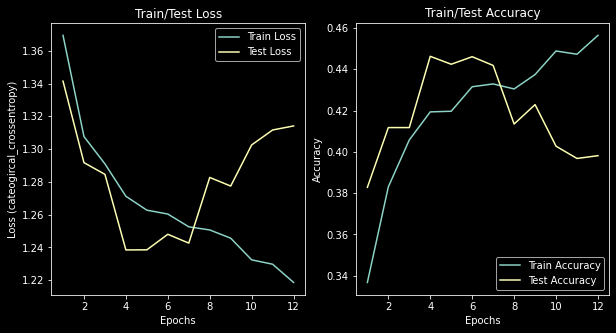

In [5]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background')

In [ ]:
y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

#this function creates a confusion matrix given the confusion matrixes of test and train
Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Mask', 'Mask'], theme = 'dark_background')

In [ ]:
assert False

In [ ]:

%%javascript
IPython.notebook.save_notebook()

In [ ]:
os.system(r'%windir%\system32\rundll32.exe powrprof.dll,SetSuspendState Hibernate')